In [1]:
using Pkg
Pkg.activate("/Users/yusuke/program/julia_module/MyPackage")
using MyPackage

using Healpix
using Plots
using NPZ
using LinearAlgebra
using LsqFit
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StatsPlots
using PyPlot
using DSP
using FFTW
gr()

hp =  pyimport("healpy")
np = pyimport("numpy")
sns = pyimport("seaborn")
plt = pyimport("matplotlib.pyplot")
sp = pyimport("scipy.optimize")
pd = pyimport("pandas")
glob = pyimport("glob")
re = pyimport("re")
os = pyimport("os")
nth = nthreads()# for parallerize

@inline function MultiTrack_calculation(
    NSIDE::Integer,
    start::Integer,
    stop::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    loop = ((stop - start) * smp_rate) + 1

    #println("time=",loop)
    res = Resolution(NSIDE)

    α = 45(π / 180)
    β = 50(π / 180)
    orbit3D = zeros(Float64, loop, 3)
    orbit2D = zeros(Float64, loop, 2)
    dif3D = zeros(Float64, loop-1, 3)
    dif2D = zeros(Float64, loop-1, 2)
    theta_axis3D = zeros(Float64, loop, 3)

    theta_axis = zeros(Float64, loop, 2)
    sky_axis = zeros(Float64, loop, 3)

    pix = zeros(Int64, loop, length(dθ))
    psi_i = zeros(Float64, loop, length(dθ))
    cb = cos(β)
    sb = sin(β)
    ca = cos(α)
    sa = sin(α)
    println("Start track calculation!")

    for j in eachindex(dθ)
        #println("j=", j)
        #origin =[cos(dθ[j]) * cos(dφ[j]); cos(dθ[j]) * sin(dφ[j]); sin(dθ[j])]
        #=
        origin = [
        cosd(dθ[j]) -sind(dθ[j]) 0
        sind(dθ[j])*cosd(dφ[j]) cosd(dθ[j])*cosd(dφ[j])  -sind(dφ[j])
        sind(dθ[j])*sind(dφ[j]) cosd(dθ[j])*sind(dφ[j])  cosd(dφ[j])
        ]*[1;0;0]
        =#
        origin = [cosd(dθ[j]); sind(dθ[j])cosd(dφ[j]); sind(dθ[j])sind(dφ[j])]

        @inbounds @threads for i in 1:loop
            t = start + (i-1)/smp_rate

            ωₐt = ((2π / 60) / 192.348)t
            ωᵦt = (0.05π / 30)t
            ωᵣt = (2π)t / (60 * 60 * 24 * 365)
            cwb = cos(ωᵦt)
            swb = sin(ωᵦt)
            cwa = cos(ωₐt)
            swa = sin(ωₐt)
            cwr = cos(ωᵣt)
            swr = sin(ωᵣt)

            rot_spin = [
                cb -sb 0
                sb*cwb cb*cwb -swb
                sb*swb cb*swb cwb
            ]
            vec_1 = @views rot_spin * origin

            rot_prec = [
                ca -sa 0
                sa*cwa ca*cwa -swa
                sa*swa ca*swa cwa
            ]
            vec_2 = @views rot_prec * vec_1

            rot_sun = [
                cwr -swr 0
                swr cwr 0
                0 0 1
            ]
            vec_3 = @views rot_sun * vec_2

            orbit3D[i, 1] = vec_3[1]
            orbit3D[i, 2] = vec_3[2]
            orbit3D[i, 3] = vec_3[3]

            ang = @views vec2ang(
                orbit3D[i, 1],
                orbit3D[i, 2],
                orbit3D[i, 3],
            )

            orbit2D[i, 1] = ang[1]
            orbit2D[i, 2] = ang[2]

            theta_axis[i, 1] = orbit2D[i, 1] + (π / 180) * 1e-7

            vec = @views ang2vec(theta_axis[i, 1], orbit2D[i, 2])
            sky_axis[i, 1] = vec[1] - orbit3D[i, 1]
            sky_axis[i, 2] = vec[2] - orbit3D[i, 2]
            sky_axis[i, 3] = vec[3] - orbit3D[i, 3]
            pix[i, j] = ang2pix(m, orbit2D[i, 1], orbit2D[i, 2])
        end

        @inbounds @threads for i in 1:loop-1
            dif3D[i, 1] = orbit3D[i+1, 1] - orbit3D[i, 1]
            dif3D[i, 2] = orbit3D[i+1, 2] - orbit3D[i, 2]
            dif3D[i, 3] = orbit3D[i+1, 3] - orbit3D[i, 3]
            dif2D[i, 1] = orbit2D[i+1, 1] - orbit2D[i, 1]
            dif2D[i, 2] = orbit2D[i+1, 2] - orbit2D[i, 2]

            Vvec = @views dif3D[i, :]
            nvec = @views sky_axis[i, :]
            inner = dot(Vvec, nvec)
            L_dif =
                √(dif3D[i, 1]^2 + dif3D[i, 2]^2 + dif3D[i, 3]^2)
            L_axis = √(
                sky_axis[i, 1]^2 +
                sky_axis[i, 2]^2 +
                sky_axis[i, 3]^2,
            )

            cos_psi = inner / (L_dif * L_axis)

            if dif2D[i, 2] > π
                dif2D[i, 2] = dif2D[i, 2] - 2π
            end
            if dif2D[i, 2] < -π
                dif2D[i, 2] = dif2D[i, 2] + 2π
            end

            judge = sign(-dif2D[i, 2])
            psi_i[i, j] = acos(cos_psi) * judge
        end
    end
    return pix, psi_i
end


function get_psi_and_pix(
    NSIDE::Integer,
    times::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    split_num = 6
    month = Int64(times/split_num)


    hit_pix = zeros(Int64, NPIX)
    theta_line_pix = Int64[]
    theta_line_psi = Float64[]

    Begin = 0
    
    deg = 90(π/180)
    dphi = 20(π/180)

    for i = 1:split_num
        println("process=", i, "/", split_num)
        stop = i*month

        #println("calc_", start, "_to_", stop)
        #println("Finish is =", times)
        PIX, PSI_i = MultiTrack_calculation(NSIDE, Begin, stop, smp_rate, dθ, dφ)

        loop_times = length(PSI_i)
        #println("Start reconstruct!")
        #println("loop_times=", loop_times)
        bore_pix = @views PIX
        #ghost_pix = @views PIX[:, 2]
        psi_i = @views PSI_i
        
        pix_pi2 = hp.pix2ang(NSIDE, bore_pix)[2]
    
        for k in 1:loop_times
            bore = bore_pix[k]
            #ghost = ghost_pix[k]
            psi = psi_i[k]
            TIME = Begin + (k-1)/smp_rate
            
            
            if pix_pi2[k] < deg + dphi
                if pix_pi2[k] > deg - dphi
                    push!(theta_line_pix, bore)
                    push!(theta_line_psi, psi)
                end
            end

            hit_pix[bore] += 1
        end
        Begin = stop + 1
    end
    
    return hit_pix, theta_line_pix, theta_line_psi
end

function dist_FWHM(copol, theta_line_pix, phi90pix)
    @. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))
    ddeg = np.deg2rad(0.36)
    FWHM = zeros(length(phi90pix)-2, 4)
    p0 = [136, 0.003]
    xdata = @views [reverse(theta[:,1]) ; -theta[:,500]]
    idx1 = [1, 125, 250, 375]
    idx2 = 500 .+ idx1
    
    for i in 2:99
        if i%10 == 0
            println(i)
        end
        
        index = np.where(theta_line_pix .== phi90pix[i])[1] .+1

        psi_in_ipix = zeros(length(index))
        @threads for i in eachindex(index)
            psi_in_ipix[i] = theta_line_psi[index[i]] 
        end

        copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)
        
        for j in 1:4
            ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
            Fit = curve_fit(gaussian2, xdata, ydata, p0)
            FWHM[i-1,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
        end

        #println(FWHM[i])
    end
    return FWHM
end

function hit_map(NSIDE, pix)
    NPIX = nside2npix(NSIDE)
    hit_pix = zeros(Int64, NPIX)
    @threads for i = 1:length(pix)
        hit_pix[pix[i]] += 1
    end
    return hit_pix
end

 Activating environment at `~/program/julia_module/MyPackage/Project.toml`


hit_map (generic function with 1 method)

In [2]:
const NSIDE = 128
const NPIX = nside2npix(NSIDE)
const m = Map{Float64,RingOrder}(NSIDE)
const day = 60 * 60 * 24
const year = day * 365
smp_rate = 5
times = year

println("SR=", smp_rate)


SR=5


In [117]:
function flip(pix)
    new_pix = 0
    if pix == 0
        new_pix = 2
    end
    if pix == 2
        new_pix = 0
    end
    if pix == 3
        new_pix = 5
    end
    if pix == 5
        new_pix = 3
    end
    if pix == 6
        new_pix = 8
    end
    if pix == 8
        new_pix = 6
    end
    if pix == 1
        new_pix = 1
    end
    if pix == 4
        new_pix = 4
    end
    if pix == 7
        new_pix = 7
    end
    return new_pix
end

function waferpix2sight(wafer_array, pixel_array)
    
    loop = length(wafer_array)
    Theta = zeros(loop)
    Phi = zeros(loop)
    beam_path = []
    
    for i in 1:loop
        wafer = wafer_array[i]
        pixel = pixel_array[i]
        switch = 0
        
        if wafer == 0 || wafer == 4 || wafer == 3 || wafer == 7
            if wafer == 0
                wafer = 3
                #println(pixel)
                pixel = flip(pixel)
                #println(pixel)
                switch += 1
            end
            if wafer == 4
                wafer = 7
                pixel = flip(pixel)
                switch += 1
            end
            
            df = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_32mm.csv")
        else
            df = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_16mm.csv")
        end
        index = np.where((df["wafer"] == wafer) & (df["pixel"] == pixel))[1] .+1
        
        param = df.loc[index[1]]
        theta = param[5]
        phi = param[6]
        name = split(param[1], "Hz")
        
        push!(beam_path, glob.glob("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/" * name[1] * "*tp.npz"))
        #beam_path[i] = glob.glob("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/" * name[1] * "*tp.npz")
        #println(beam_path)
        
        if switch == 0
            if wafer == 1 || wafer == 5 || wafer == 2 || wafer == 3 || wafer == 6 || wafer == 7
                #println(phi)
                phi = 180-phi
            end
        end
        
        #phi = 180 - phi
        Theta[i] = theta
        Phi[i] = phi
    end
    
    #println("Theta=", theta)
    #println("Phi=", phi)
    return Theta, Phi, beam_path
end
    


waferpix2sight (generic function with 1 method)

In [78]:
a = [0,3,4,7]
wafs32 = zeros(Int, 40)
pixs32 = zeros(Int, 40)
for i in 1:4
    for j in 1:9
        wafs32[10(i-1)+j] = a[i]
        pixs32[10(i-1)+j] = j-1
    end
end

df16 = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_16mm.csv")

WF_focal_plane = [np.array(df16["wafer"]); wafs32]
PX_focal_plane = [np.array(df16["pixel"]); pixs32]
a

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[78]:12
└ @ Core In[78]:12
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[78]:14
└ @ Core In[78]:14


4-element Array{Int64,1}:
 0
 3
 4
 7

In [121]:
prec1 = 60*60*3
WF_LFT_edge = [0,3,7,4]
PX_LFT_edge = [0,2,8,6]
th, ph, bpath = waferpix2sight(WF_focal_plane, PX_focal_plane)
#th, ph, bpath = waferpix2sight(WF_LFT_edge, PX_LFT_edge)
pix, psi_i= MultiTrack_calculation(NSIDE, 0, prec1, smp_rate, th, ph .+90)

Start track calculation!


([91009 91009 … 83342 113026; 91009 91009 … 83342 113026; … ; 129921 129921 … 122254 149890; 129921 129921 … 122254 149890], [3.0775432179673103 3.0775432179673103 … 3.046187133829392 -3.0133135783228377; 3.076900831904082 3.076900831904082 … 3.0456637190566385 -3.013961230699926; … ; 3.074954458130167 3.074954458130167 … 2.983548399705266 -3.0179943570584147; 0.0 0.0 … 0.0 0.0])

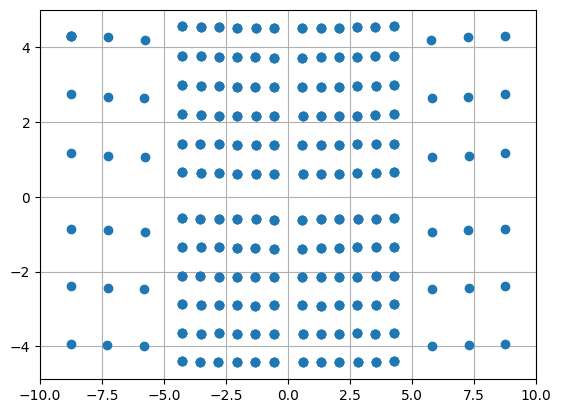

In [122]:
x = th .* cosd.(ph)
y = th .* sind.(ph)
plt.plot(x,y,"o")
plt.xlim(-10,10)
plt.grid()

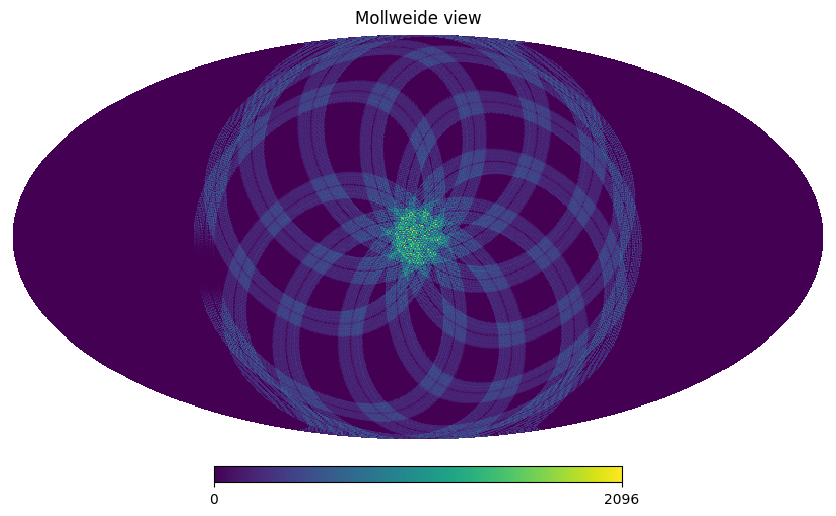

In [123]:
I_lu = hit_map(NSIDE, pix)
hp.mollview(I_lu, norm="None")

In [147]:
#th = [0, 0, _theta]
#ph = [0, 0, φ] .+ 90

PI = 180

φp = 153.8 #(w:3,pix2)
φm = 204.20 #(w:7,pix2)

t_mp = 9.74
p_mp = PI-φp
println(p_mp)

t_mm = 9.74
p_mm = PI-φm
println(p_mm)

t_pp = 9.74
p_pp = φp
println(p_pp)

t_pm = 9.74
p_pm = φm
println(p_pm)

prec1 = 60*60*3

th1 = [0, 0, t_pp, t_mp, t_mm, t_pm]
ph1 = [0, 0, p_pp, p_mp, p_mm, p_pm] .+ 90

#pix, psi_i= MultiTrack_calculation(NSIDE, 0, 1000, smp_rate, th, ph)
#I_lu = hit_map(NSIDE, pix)
#hp.mollview(I_lu)


26.19999999999999
-24.19999999999999
153.8
204.2


4-element Array{Float64,1}:
 153.8
  26.19999999999999
 -24.19999999999999
 204.2

In [24]:
dth = [_theta]
dph = [φ]
tick()
hit_pix, theta_line_pix, theta_line_psi = get_psi_and_pix(NSIDE, times, smp_rate, dth, dph)
tock()

┌ Info:  started timer at: 2020-08-28T20:12:53.349
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:32


process=1/6
Start track calculation!
j=1
process=2/6
Start track calculation!
j=1
process=3/6
Start track calculation!
j=1
process=4/6
Start track calculation!
j=1
process=5/6
Start track calculation!
j=1
process=6/6
Start track calculation!
j=1


┌ Info:        493.832749982s: 8 minutes, 13 seconds, 832 milliseconds
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:39


In [25]:
#Theta_line, phi90pix = MyPackage.lineget(NSIDE, theta_line_pix, theta_line_psi, 256)
div = 100
elev = np.linspace(0, π, div)
azim = ones(div) .* π / 2
phi90pix = hp.ang2pix(NSIDE, elev, azim) .+1
#np.save("/Users/yusuke/program/LiteBIRD_sim/beam_study", phi90pix)
div

100

In [27]:
#beam_path = "/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/FWHM_study/use_data/npz_data/m92_p92_blue/m92_p92_100G_000deg_tp.npz"
#file_name = split(beam_path, "/")
#main_name = split(file_name[12],".npz")[1]

data = npzread(beam_path[1])

N = 1001
phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
X = theta .* cos.( phi )
Y = theta .* sin.( phi )
copol = np.reshape(data["copol"], [N, N])
length(theta)


1002001

pix=[89.10471701342988, 90.703125]


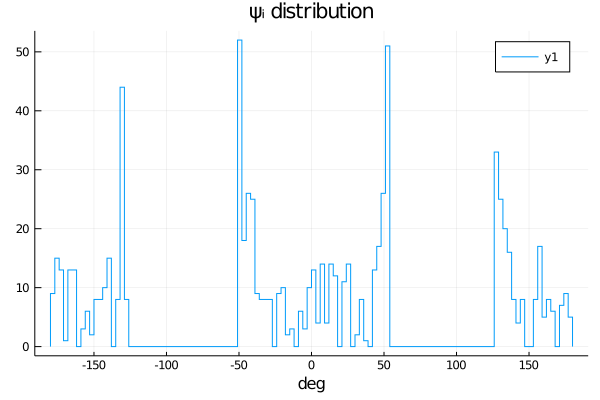

In [28]:
#print(Int.(Theta_line[1,:])[220])
#index = np.where(Int.(Theta_line[1,:]) .==52608)[1] .+1
pixnmb = 50
index = np.where(theta_line_pix .== phi90pix[pixnmb])[1] .+1

psi_in_ipix = zeros(length(index))
for i in 1:length(index)
    psi_in_ipix[i] = theta_line_psi[index[i]] 
end
ddeg = np.deg2rad(0.36)
println("pix=",np.rad2deg(hp.pix2ang(NSIDE,phi90pix[pixnmb])))

copol = np.reshape(data["copol"], [N, N])
copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

edge = -180:3:180

psi_dist = fit(Histogram, np.rad2deg(psi_in_ipix), edge)

Plots.plot(psi_dist,
    title = "ψᵢ distribution",
    xlabel="deg",
    seriestype = :step, fmt=:png)

[16.2960643243503, 0.007244840779786915]
FWHM=58.648978484050446


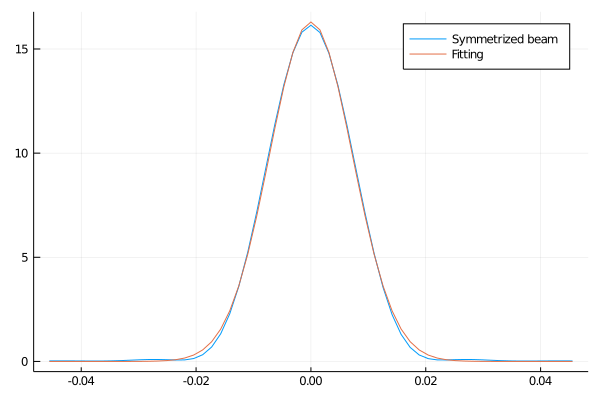

In [29]:
@. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))

cut=30
a = [reverse(copol_sym[1:cut,1])  ;copol_sym[1:cut,501]]
b = [reverse(theta[1:cut,1]) ; -theta[1:cut,501]]


p0 = [106804, 0.000487]
xdata = b
ydata = a

Fit = curve_fit(gaussian2, xdata, ydata, p0)
println(Fit.param)

gauss = gaussian2(xdata, Fit.param)
FWHM = 2*√(2*log(2))*Fit.param[2]
println("FWHM=", np.rad2deg(FWHM)*60)
Plots.plot(xdata, ydata, label = "Symmetrized beam", fmt=:png)
Plots.plot!(xdata, gauss, label = "Fitting")

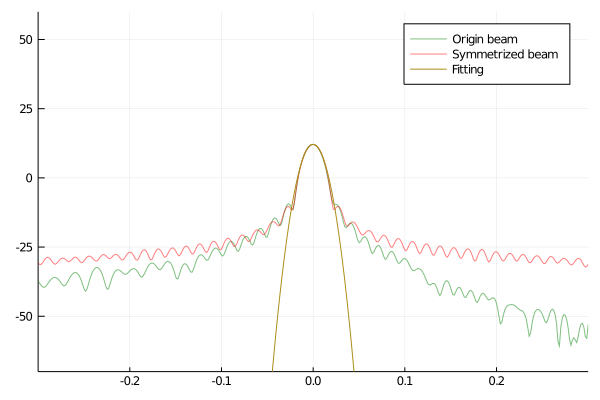

In [30]:
Plots.plot( theta[:,1], 10log10.(copol[:,1]), color=:green, alpha=0.5, label="Origin beam", fmt=:png)
Plots.plot!( -theta[:,500], 10log10.(copol[:,500]), color=:green, alpha=0.5, label=:none)

Plots.plot!( theta[:,1], 10log10.(copol_sym[:,1]), color=:red, alpha=0.5, label="Symmetrized beam")
Plots.plot!( -theta[:,501], 10log10.(copol_sym[:,501]), color=:red, alpha=0.5, label=:none)

Plots.plot!(xdata, 10log10.(gauss), label = "Fitting", xlim=(-0.3,0.3),ylims=(-70,60), fmt=:png)

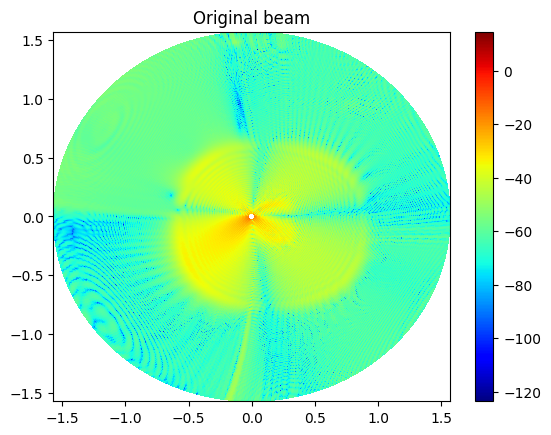

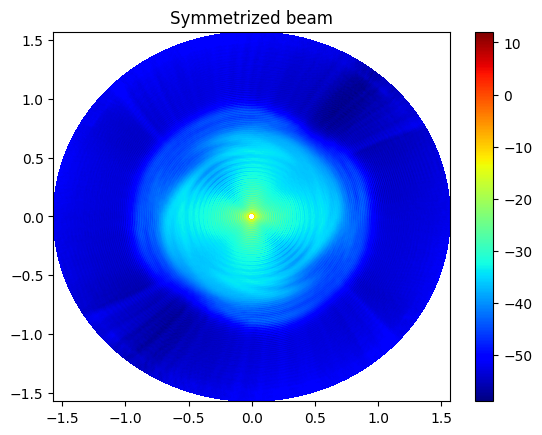

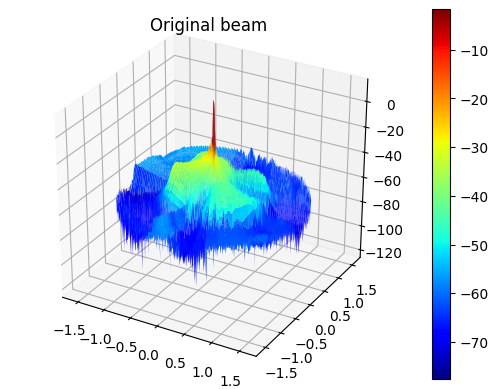

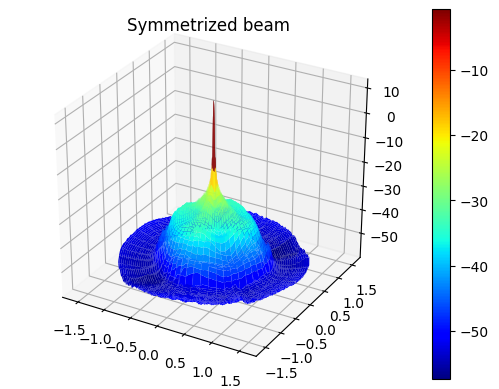

PyObject Text(0.5, 0.92, 'Symmetrized beam')

In [39]:
#=
data = npzread("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m189_p84_68.0G_000deg_tp.npz")

N = 1001
phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
X = theta .* cos.( phi )
Y = theta .* sin.( phi )
copol = np.reshape(data["copol"], [N, N])
=#
figure(111)
plt.title("Original beam")
pcolormesh(X, Y, 10log10.(copol), cmap = "jet" )
pp = plt.colorbar( orientation ="vertical")


figure(222)
plt.title("Symmetrized beam")
pcolormesh(X, Y, 10log10.(copol_sym), cmap = "jet" )
pp = plt.colorbar( orientation ="vertical")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, 10log10.(copol), cmap="jet", linewidth=0)
fig.colorbar(surf)
ax.set_title("Original beam")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, 10log10.(copol_sym), cmap="jet", linewidth=0)
fig.colorbar(surf)
ax.set_title("Symmetrized beam")

In [33]:
function dist_FWHM(copol, theta_line_pix, phi90pix, p0)
    @. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))
    ddeg = np.deg2rad(0.36)
    FWHM = zeros(length(phi90pix), 4)
    #p0 = [50435, 0.00487]
    xdata = @views [reverse(theta[:,1]) ; -theta[:,500]]
    idx1 = [1, 125, 250, 375]
    idx2 = 500 .+ idx1
    
    for i in eachindex(phi90pix)
        if i%10 == 0
            println(i)
        end
        
        index = np.where(theta_line_pix .== phi90pix[i])[1] .+1

        psi_in_ipix = zeros(length(index))
        @threads for i in eachindex(index)
            psi_in_ipix[i] = theta_line_psi[index[i]] 
        end
        
        if length(psi_in_ipix) != 0
            copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

            for j in 1:4
                ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
                Fit = curve_fit(gaussian2, xdata, ydata, p0)
                FWHM[i,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
            end
        end
    end
    loop = length(np.nonzero(FWHM[:,1])[1])
    FWHM_ = zeros(loop, 4)
    for i in 1:loop
        @threads for j in 1:4
            FWHM_[i,j] = FWHM[i+Int((100-loop)/2),j]
        end
    end
    return FWHM_
end

fwhm = dist_FWHM(copol, theta_line_pix, phi90pix, p0)

10
20
30
40
50
60
70
80
90
100


96×4 Array{Float64,2}:
 58.7146  58.6696  58.6439  58.6872
 58.6774  58.6648  58.6795  58.6925
 58.6762  58.5995  58.6818  58.7566
 58.6711  58.6422  58.686   58.7161
 58.7169  58.5565  58.6357  58.8053
 58.6896  58.4529  58.6526  58.9188
 58.7269  58.5913  58.6404  58.756
 58.6412  58.6348  58.7508  58.6883
 58.6807  58.8666  58.7168  58.455
 58.6363  58.9078  58.7493  58.426
 58.6072  59.0034  58.7781  58.3318
 58.5699  59.0449  58.8006  58.3062
 58.5597  59.0121  58.8063  58.3427
  ⋮                         
 58.5487  58.898   58.8327  58.4407
 58.6226  58.9021  58.7763  58.4189
 58.7337  58.853   58.6643  58.4668
 58.6755  58.8922  58.7186  58.4318
 58.6731  58.769   58.7204  58.5525
 58.738   58.5405  58.6272  58.8039
 58.7737  58.4168  58.5705  58.9473
 58.7866  58.5542  58.5641  58.8054
 58.7134  58.6302  58.6409  58.7275
 58.7299  58.6555  58.6239  58.7036
 58.666   58.6454  58.6916  58.7102
 58.6212  58.6098  58.7414  58.7408

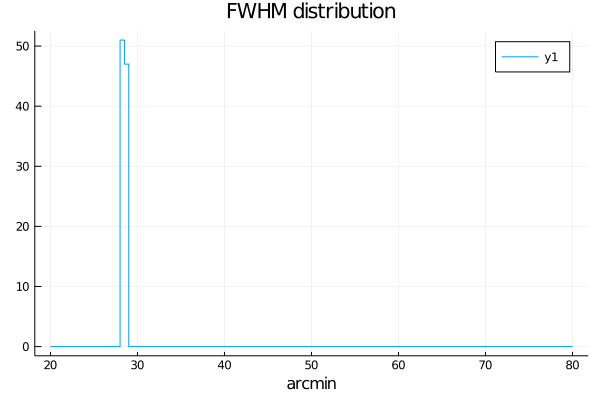

In [44]:
edge = 20:0.5:80
fwhm_dist = fit(Histogram, FWHM_[:,1], edge)

Plots.plot(fwhm_dist,
    title = "FWHM distribution",
    xlabel="arcmin",
    seriestype = :step, fmt=:png)

In [239]:
savepath = "/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/calc_fwhm_dist/"
np.savez_compressed(savepath * main_name * "_fwhm", data=FWHM_)

In [240]:
a = npzread(savepath * main_name * "_fwhm" * ".npz")
a["data"]

98×4 Array{Float64,2}:
 43.8377  43.8495  43.8519  43.8401
 43.8547  43.8103  43.8343  43.8799
 43.8799  43.8337  43.81    43.8561
 43.8765  43.8444  43.8142  43.8452
 43.9506  43.7949  43.7402  43.8943
 44.0774  43.7205  43.6158  43.9659
 43.7266  43.8619  43.9551  43.8366
 43.6492  43.9576  44.0352  43.7403
 43.6183  43.9821  44.0684  43.7133
 43.534   43.9626  44.1544  43.7311
 43.5195  43.9838  44.1704  43.7091
 43.5678  43.9799  44.1269  43.7083
 43.5006  43.9635  44.1906  43.7275
  ⋮                         
 43.5095  43.9556  44.1808  43.7376
 43.5821  43.9017  44.106   43.7926
 43.6459  44.0082  44.0411  43.6877
 43.5409  43.896   44.1441  43.8001
 43.6879  43.9784  43.9942  43.7201
 43.7551  43.8273  43.9262  43.8698
 44.1278  43.744   43.5614  43.9414
 43.958   43.8381  43.7305  43.8501
 43.8912  43.816   43.7973  43.873
 43.8676  43.8582  43.8213  43.8314
 43.8561  43.8172  43.833   43.8721
 43.8536  43.8649  43.836   43.824